In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
import matplotlib.pyplot as plt
import seaborn as sns

import ast
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import os
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['test.csv', 'train.csv', 'sample_submission.csv']


Input the dataset and see the shape etc

In [2]:
train=pd.read_csv("../input/train.csv")
test=pd.read_csv("../input/test.csv")

In [3]:
train.head()

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,/tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,/w9Z7A0GHEhIp7etpj0vyKOeU1Wx.jpg,"[{'name': 'Walt Disney Pictures', 'id': 2}]","[{'iso_3166_1': 'US', 'name': 'United States o...",8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435
2,3,NaN,3300000,"[{'id': 18, 'name': 'Drama'}]",http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,/lIv1QinFqz4dlp5U4lQ6HaiskOZ.jpg,"[{'name': 'Bold Films', 'id': 2266}, {'name': ...","[{'iso_3166_1': 'US', 'name': 'United States o...",10/10/14,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The road to greatness can take you to the edge.,Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000
3,4,NaN,1200000,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",http://kahaanithefilm.com/,tt1821480,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,/aTXRaPrWSinhcmCrcfJK17urp3F.jpg,NaN,"[{'iso_3166_1': 'IN', 'name': 'India'}]",3/9/12,122.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,Kahaani,"[{'id': 10092, 'name': 'mystery'}, {'id': 1054...","[{'cast_id': 1, 'character': 'Vidya Bagchi', '...","[{'credit_id': '52fe48779251416c9108d6eb', 'de...",16000000
4,5,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",NaN,tt1380152,ko,마린보이,Marine Boy is the story of a former national s...,1.148070,/m22s7zvkVFDU9ir56PiiqIEWFdT.jpg,NaN,"[{'iso_3166_1': 'KR', 'name': 'South Korea'}]",2/5/09,118.0,"[{'iso_639_1': 'ko', 'name': '한국어/조선말'}]",Released,NaN,Marine Boy,NaN,"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...","[{'credit_id': '52fe464b9251416c75073b43', 'de...",3923970


In [4]:
train.describe(include='all')

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
count,3000.000000,604,3.000000e+03,2993,946,3000,3000,3000,2992,3000.000000,2999,2844,2945,3000,2998.000000,2980,3000,2403,3000,2724,2987,2984,3.000000e+03
unique,NaN,422,NaN,872,941,3000,36,2975,2992,NaN,2999,2383,321,2398,NaN,401,2,2400,2969,2648,2975,2984,NaN
top,NaN,"[{'id': 645, 'name': 'James Bond Collection', ...",NaN,"[{'id': 18, 'name': 'Drama'}]",http://www.transformersmovie.com/,tt1600196,en,Red Dawn,Chris is the top brain who just wants to party...,NaN,/5dgjgBMWHcOrXL7EbGnU73WpXNB.jpg,"[{'name': 'Paramount Pictures', 'id': 4}]","[{'iso_3166_1': 'US', 'name': 'United States o...",9/10/15,NaN,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Based on a true story.,The Three Musketeers,"[{'id': 10183, 'name': 'independent film'}]",[],"[{'credit_id': '56cf3ffd9251413e59002f23', 'de...",NaN
freq,NaN,16,NaN,266,4,1,2575,2,1,NaN,1,51,1752,5,NaN,1817,2996,3,2,27,13,1,NaN
mean,1500.500000,NaN,2.253133e+07,NaN,NaN,NaN,NaN,NaN,NaN,8.463274,NaN,NaN,NaN,NaN,107.856571,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.672585e+07
std,866.169729,NaN,3.702609e+07,NaN,NaN,NaN,NaN,NaN,NaN,12.104000,NaN,NaN,NaN,NaN,22.086434,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.375323e+08
min,1.000000,NaN,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,0.000001,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000e+00
25%,750.750000,NaN,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,4.018053,NaN,NaN,NaN,NaN,94.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.379808e+06
50%,1500.500000,NaN,8.000000e+06,NaN,NaN,NaN,NaN,NaN,NaN,7.374861,NaN,NaN,NaN,NaN,104.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.680707e+07
75%,2250.250000,NaN,2.900000e+07,NaN,NaN,NaN,NaN,NaN,NaN,10.890983,NaN,NaN,NaN,NaN,118.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.891920e+07


In [5]:
train.isnull().sum()

id                          0
belongs_to_collection    2396
budget                      0
genres                      7
homepage                 2054
imdb_id                     0
original_language           0
original_title              0
overview                    8
popularity                  0
poster_path                 1
production_companies      156
production_countries       55
release_date                0
runtime                     2
spoken_languages           20
status                      0
tagline                   597
title                       0
Keywords                  276
cast                       13
crew                       16
revenue                     0
dtype: int64

In [6]:
print (test.shape,train.shape)

(4398, 22) (3000, 23)


In [7]:
#check number of unique language
train['original_language'].unique()

array(['en', 'hi', 'ko', 'sr', 'fr', 'it', 'nl', 'zh', 'es', 'cs', 'ta',
       'cn', 'ru', 'tr', 'ja', 'fa', 'sv', 'de', 'te', 'pt', 'mr', 'da',
       'fi', 'el', 'ur', 'he', 'no', 'ar', 'nb', 'ro', 'vi', 'pl', 'hu',
       'ml', 'bn', 'id'], dtype=object)

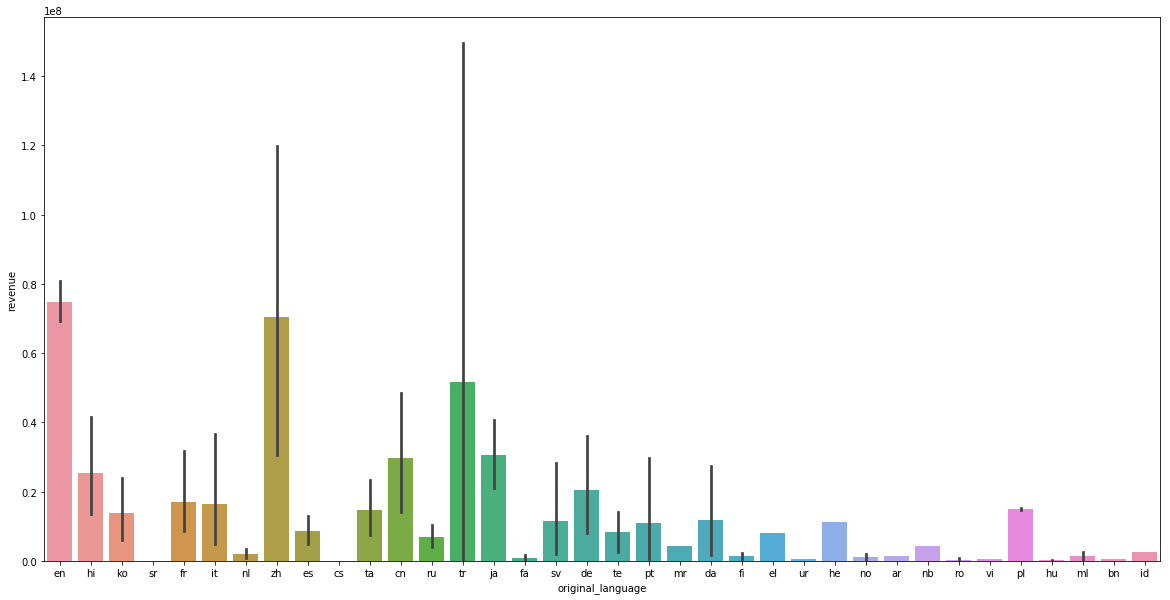

In [8]:
# Revenue with respect to each language
fig = plt.figure(figsize=(20,10))
sns.barplot('original_language','revenue',data=train)

#Budget

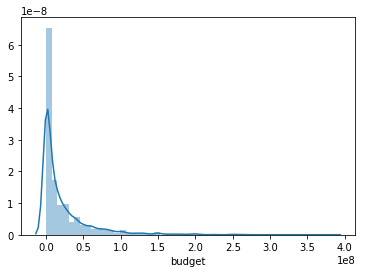

In [9]:
sns.distplot(train["budget"])

We can see that our budget is right skewed which is expected because not all movies cast Popular actors. 

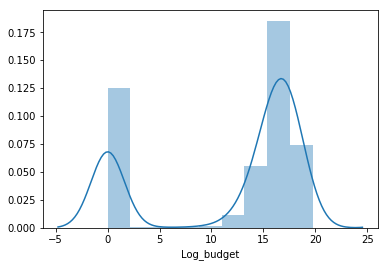

In [10]:
train['Log_budget']=np.log1p(train['budget'])
test['Log_budget']=np.log1p(test['budget'])
sns.distplot(train['Log_budget'])

 Budget contain many zero value budget which is not possible,so we will deal with null values later.

In [11]:
col=['budget','Log_budget','revenue']
train[col].corr()

,budget,Log_budget,revenue
budget,1.000000,0.489663,0.752965
Log_budget,0.489663,1.000000,0.325925
revenue,0.752965,0.325925,1.000000


Here we will split date into different parts and form column for individual.

In [12]:
def date(df):
    df['release_date'] = pd.to_datetime(df['release_date'])
    df['release_year'] = df['release_date'].dt.year
    df['release_month'] = df['release_date'].dt.month
    df['release_day'] = df['release_date'].dt.day
    df['release_quarter'] = df['release_date'].dt.quarter
    df.drop(columns=['release_date'], inplace=True)
    return df

train=date(train)
test=date(test)
    

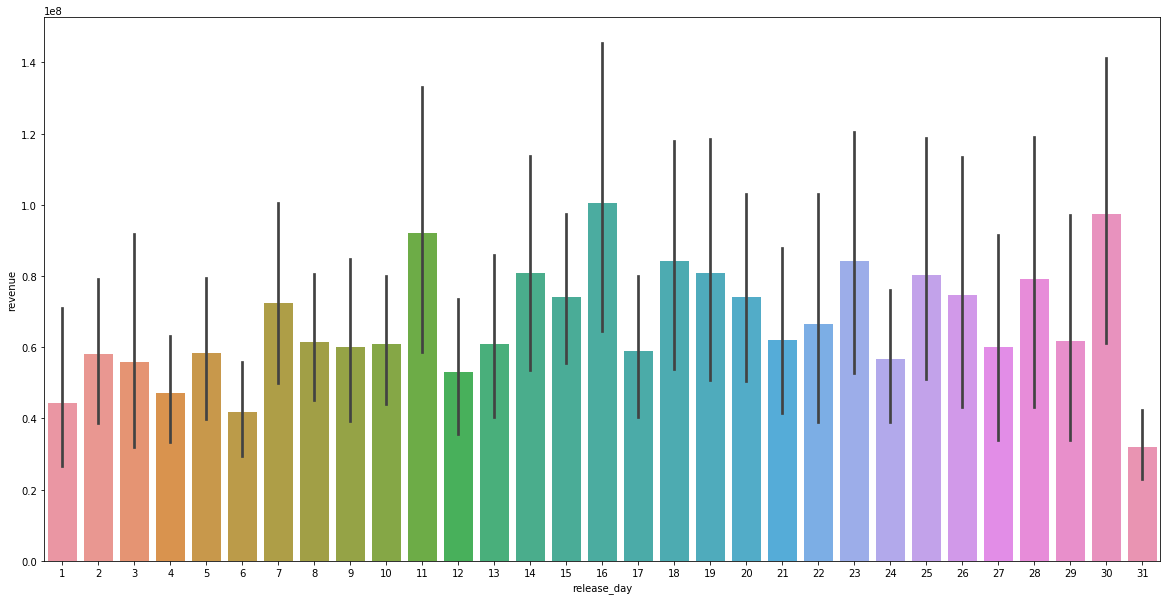

In [13]:
fig = plt.figure(figsize=(20,10))
sns.barplot(x="release_day",y="revenue",data=train)


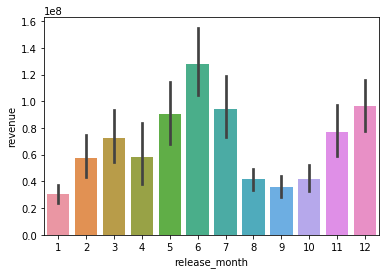

In [14]:
sns.barplot(x="release_month",y="revenue",data=train)

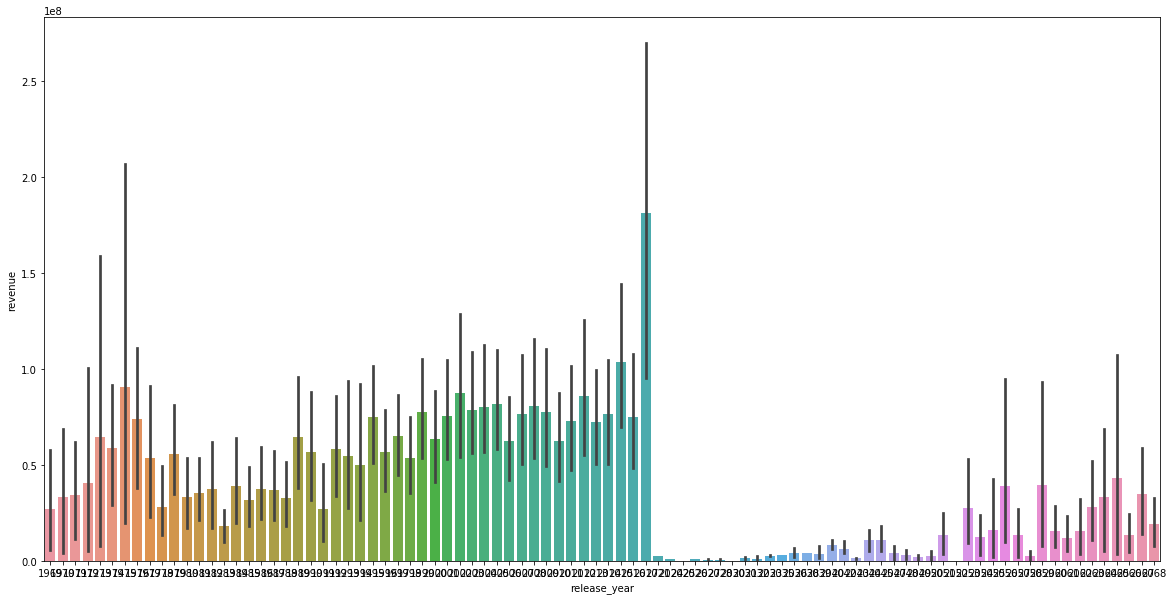

In [15]:
fig = plt.figure(figsize=(20,10))

sns.barplot(x="release_year",y="revenue",data=train)


In [16]:
# we will add genre count for each movies
genres_count=[]
for i in train['genres']:
    if(not(pd.isnull(i))):
        
        genres_count.append(len(eval(i)))
        
    else:
        genres_count.append(0)
train['num_genres'] = genres_count

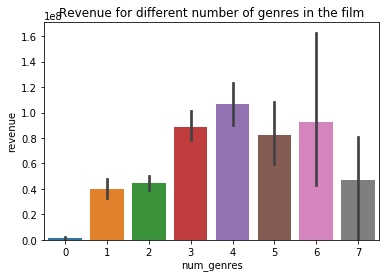

In [17]:
sns.barplot(x='num_genres', y='revenue', data=train);
plt.title('Revenue for different number of genres in the film');


In [18]:
#genre count for test data
genres_count_test=[]
for i in test['genres']:
    if(not(pd.isnull(i))):
        
        genres_count_test.append(len(eval(i)))
        
    else:
        genres_count_test.append(0)
test['num_genres'] = genres_count_test

In [19]:
#Dropping genre
train.drop(['genres'],axis=1, inplace = True)
test.drop(['genres'],axis=1, inplace = True)


In [20]:
#adding number of production countries
prod_comp_count=[]
for i in train['production_companies']:
    if(not(pd.isnull(i))):
        
        prod_comp_count.append(len(eval(i)))
        
    else:
        prod_comp_count.append(0)
train['num_prod_companies'] = prod_comp_count

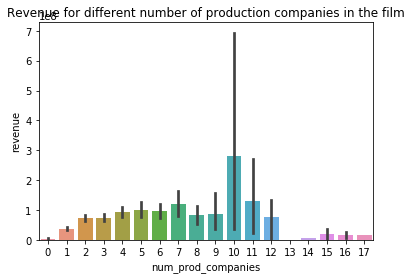

In [21]:
sns.barplot(x='num_prod_companies', y='revenue', data=train);
plt.title('Revenue for different number of production companies in the film');


In [22]:
prod_comp_count_test=[]
for i in test['production_companies']:
    if(not(pd.isnull(i))):
        
        prod_comp_count_test.append(len(eval(i)))
        
    else:
        prod_comp_count_test.append(0)
test['num_prod_companies'] = prod_comp_count_test


In [23]:
#Dropping production companies
train.drop(['production_companies'],axis=1, inplace = True)
test.drop(['production_companies'],axis=1, inplace = True)

In [24]:
#Adding num of production countries
prod_coun_count=[]
for i in train['production_countries']:
    if(not(pd.isnull(i))):
        
        prod_coun_count.append(len(eval(i)))
        
    else:
        prod_coun_count.append(0)
train['num_prod_countries'] = prod_coun_count

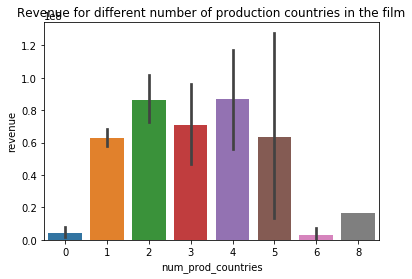

In [25]:
sns.barplot(x='num_prod_countries', y='revenue', data=train);
plt.title('Revenue for different number of production countries in the film');


In [26]:
prod_coun_count_test=[]
for i in test['production_countries']:
    if(not(pd.isnull(i))):
        
        prod_coun_count_test.append(len(eval(i)))
        
    else:
        prod_coun_count_test.append(0)
test['num_prod_countries'] = prod_coun_count_test

In [27]:
#Dropping production countries
train.drop(['production_countries'],axis=1, inplace = True)
test.drop(['production_countries'],axis=1, inplace = True)

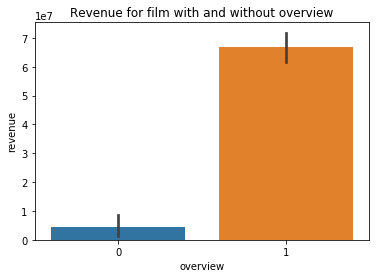

In [28]:
#Here mapping overview represent to 1 anf null to zero
train['overview']=train['overview'].apply(lambda x: 0 if pd.isnull(x) else 1)
test['overview']=test['overview'].apply(lambda x: 0 if pd.isnull(x) else 1)
sns.barplot(x='overview', y='revenue', data=train);
plt.title('Revenue for film with and without overview');


In [29]:
train= train.drop(['overview'],axis=1)
test= test.drop(['overview'],axis=1)

In [30]:
#Addding num of cast in movie
total_cast=[]
for i in train['cast']:
    if(not(pd.isnull(i))):
        
        total_cast.append(len(eval(i)))
        
    else:
        total_cast.append(0)
train['cast_count'] = total_cast

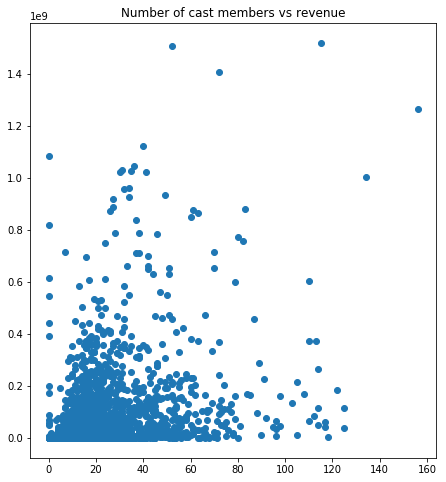

In [31]:
#Visualising through scatter plot for cast number
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.scatter(train['cast_count'], train['revenue'])
plt.title('Number of cast members vs revenue');


In [32]:
total_cast=[]
for i in test['cast']:
    if(not(pd.isnull(i))):
        
        total_cast.append(len(eval(i)))
        
    else:
        total_cast.append(0)
test['cast_count'] = total_cast

In [33]:
train= train.drop(['cast'],axis=1)
test= test.drop(['cast'],axis=1)

In [34]:
#Adding num of crews in movies
total_crew=[]
for i in train['crew']:
    if(not(pd.isnull(i))):
        
        total_crew.append(len(eval(i)))
        
    else:
        total_crew.append(0)
train['crew_count'] = total_crew

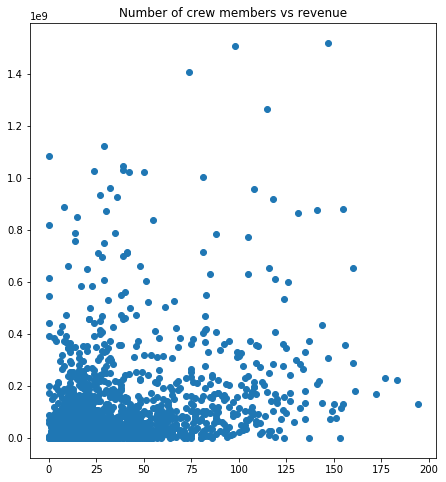

In [35]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.scatter(train['crew_count'], train['revenue'])
plt.title('Number of crew members vs revenue');

In [36]:
total_crew=[]
for i in test['crew']:
    if(not(pd.isnull(i))):
        
        total_crew.append(len(eval(i)))
        
    else:
        total_crew.append(0)
test['crew_count'] = total_crew

In [37]:
train= train.drop(['crew'],axis=1)
test= test.drop(['crew'],axis=1)

In [38]:
train= train.drop(['original_title'],axis=1)
test= test.drop(['original_title'],axis=1)

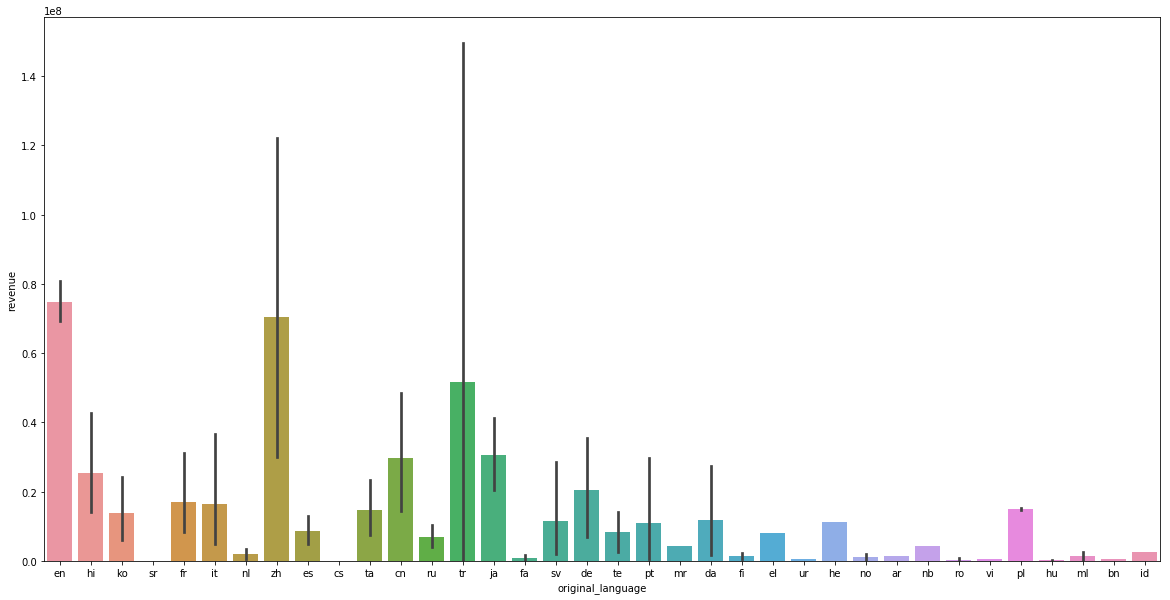

In [39]:
fig = plt.figure(figsize=(20,10))
sns.barplot('original_language','revenue',data=train)

we can see from graph 'en' and 'zh ' are highest revenue generating language, so we will consider them only.****

In [40]:
train['original_language'] =train['original_language'].apply(lambda x: 1 if x=='en' else(2 if x=='zh' else 0))
test['original_language'] =test['original_language'].apply(lambda x: 1 if x=='en' else(2 if x=='zh' else 0))

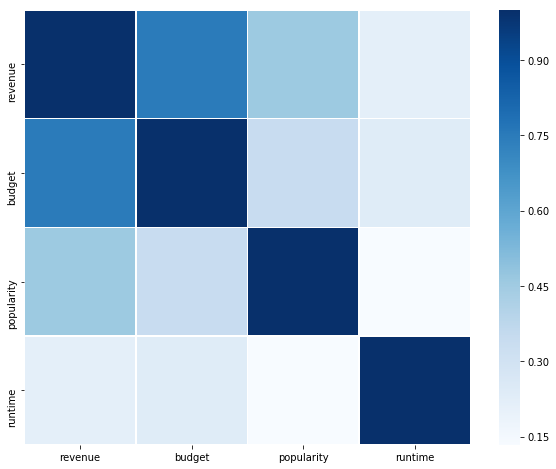

In [41]:
col = ['revenue','budget','popularity','runtime']

plt.subplots(figsize=(10, 8))

corr = train[col].corr()

sns.heatmap(corr, xticklabels=col,yticklabels=col, linewidths=.5,cmap="Blues")

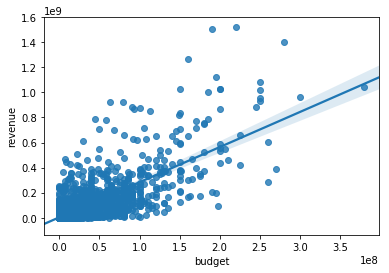

In [42]:
#budget and revenue are highly correlated
sns.regplot(x="budget", y="revenue", data=train)

In [43]:
#status
train.drop(['status'],axis=1,inplace =True)
test.drop(['status'],axis=1,inplace =True)


In [44]:
# We will drop useless column 
train=train.drop(['Keywords'],axis=1)
train=train.drop(['title'],axis=1)
test=test.drop(['Keywords'],axis=1)
test=test.drop(['title'],axis=1)

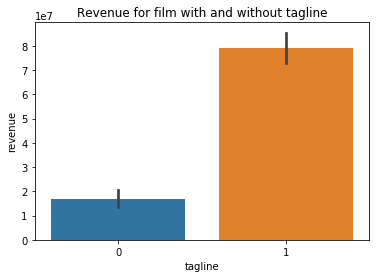

In [45]:
#tagline 
train['tagline']=train['tagline'].apply(lambda x: 0 if pd.isnull(x) else 1)
test['tagline']=test['tagline'].apply(lambda x: 0 if pd.isnull(x) else 1)
sns.barplot(x='tagline', y='revenue', data=train);
plt.title('Revenue for film with and without tagline');

In [46]:
#runtime has 2 nulls; setting it to the mean
#filling nulls in test
train['runtime']=train['runtime'].fillna(train['runtime'].mean())
test['runtime']=test['runtime'].fillna(test['runtime'].mean())


In [47]:
#adding number of spoken languages for each movie
spoken_count=[]
for i in train['spoken_languages']:
    if(not(pd.isnull(i))):
        
        spoken_count.append(len(eval(i)))
        
    else:
        spoken_count.append(0)
train['spoken_count'] = spoken_count


spoken_count_test=[]
for i in test['spoken_languages']:
    if(not(pd.isnull(i))):
        
        spoken_count_test.append(len(eval(i)))
        
    else:
        spoken_count_test.append(0)
test['spoken_count'] = spoken_count_test

In [48]:
train.drop(['spoken_languages'],axis=1,inplace=True)
test.drop(['spoken_languages'],axis=1,inplace=True)


In [49]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 22 columns):
id                       3000 non-null int64
belongs_to_collection    604 non-null object
budget                   3000 non-null int64
homepage                 946 non-null object
imdb_id                  3000 non-null object
original_language        3000 non-null int64
popularity               3000 non-null float64
poster_path              2999 non-null object
runtime                  3000 non-null float64
tagline                  3000 non-null int64
revenue                  3000 non-null int64
Log_budget               3000 non-null float64
release_year             3000 non-null int64
release_month            3000 non-null int64
release_day              3000 non-null int64
release_quarter          3000 non-null int64
num_genres               3000 non-null int64
num_prod_companies       3000 non-null int64
num_prod_countries       3000 non-null int64
cast_count               3000 

In [50]:

train.isnull().sum()

id                          0
belongs_to_collection    2396
budget                      0
homepage                 2054
imdb_id                     0
original_language           0
popularity                  0
poster_path                 1
runtime                     0
tagline                     0
revenue                     0
Log_budget                  0
release_year                0
release_month               0
release_day                 0
release_quarter             0
num_genres                  0
num_prod_companies          0
num_prod_countries          0
cast_count                  0
crew_count                  0
spoken_count                0
dtype: int64

In [51]:
train.drop(['imdb_id','poster_path'],axis=1,inplace=True)
test.drop(['imdb_id','poster_path'],axis=1,inplace=True)

In [52]:
train=train.drop(['homepage'],axis =1)
test=test.drop(['homepage'],axis =1)

In [53]:
for i, e in enumerate(train['belongs_to_collection'][:5]):
    print(i, e)

0 [{'id': 313576, 'name': 'Hot Tub Time Machine Collection', 'poster_path': '/iEhb00TGPucF0b4joM1ieyY026U.jpg', 'backdrop_path': '/noeTVcgpBiD48fDjFVic1Vz7ope.jpg'}]
1 [{'id': 107674, 'name': 'The Princess Diaries Collection', 'poster_path': '/wt5AMbxPTS4Kfjx7Fgm149qPfZl.jpg', 'backdrop_path': '/zSEtYD77pKRJlUPx34BJgUG9v1c.jpg'}]
2 nan
3 nan
4 nan


In [54]:
#train['belongs_to_collection_ISMISSING']=(train.belongs_to_collection.str.strip()=='').astype(int)
#test['belongs_to_collection_ISMISSING']=(test.belongs_to_collection.str.strip()=='').astype(int)

In [55]:
# Belong to collection contain lots of null values so we will not consider him for model generation
train.drop(['belongs_to_collection'],axis=1,inplace=True)
test.drop(['belongs_to_collection'],axis=1,inplace=True)

In [56]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 18 columns):
id                    3000 non-null int64
budget                3000 non-null int64
original_language     3000 non-null int64
popularity            3000 non-null float64
runtime               3000 non-null float64
tagline               3000 non-null int64
revenue               3000 non-null int64
Log_budget            3000 non-null float64
release_year          3000 non-null int64
release_month         3000 non-null int64
release_day           3000 non-null int64
release_quarter       3000 non-null int64
num_genres            3000 non-null int64
num_prod_companies    3000 non-null int64
num_prod_countries    3000 non-null int64
cast_count            3000 non-null int64
crew_count            3000 non-null int64
spoken_count          3000 non-null int64
dtypes: float64(3), int64(15)
memory usage: 422.0 KB


In [57]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4398 entries, 0 to 4397
Data columns (total 17 columns):
id                    4398 non-null int64
budget                4398 non-null int64
original_language     4398 non-null int64
popularity            4398 non-null float64
runtime               4398 non-null float64
tagline               4398 non-null int64
Log_budget            4398 non-null float64
release_year          4397 non-null float64
release_month         4397 non-null float64
release_day           4397 non-null float64
release_quarter       4397 non-null float64
num_genres            4398 non-null int64
num_prod_companies    4398 non-null int64
num_prod_countries    4398 non-null int64
cast_count            4398 non-null int64
crew_count            4398 non-null int64
spoken_count          4398 non-null int64
dtypes: float64(7), int64(10)
memory usage: 584.2 KB


In [58]:
train.head()

,id,budget,original_language,popularity,runtime,tagline,revenue,Log_budget,release_year,release_month,release_day,release_quarter,num_genres,num_prod_companies,num_prod_countries,cast_count,crew_count,spoken_count
0,1,14000000,1,6.575393,93.0,1,12314651,16.454568,2015,2,20,1,1,3,1,24,72,1
1,2,40000000,1,8.248895,113.0,1,95149435,17.504390,2004,8,6,3,4,1,1,20,9,1
2,3,3300000,1,64.299990,105.0,1,13092000,15.009433,2014,10,10,4,1,3,1,51,64,1
3,4,1200000,0,3.174936,122.0,0,16000000,13.997833,2012,3,9,1,2,0,1,7,3,2
4,5,0,0,1.148070,118.0,0,3923970,0.000000,2009,2,5,1,2,0,1,4,2,1


In [59]:
train=train.drop(['id'],axis=1)
test=test.drop(['id'],axis=1)


In [60]:
X=train.drop(['revenue'],axis=1)
y=train['revenue']

splitting train into train and test to see how well model works and cross validation of dataset into different model for reducing overfitting


In [61]:

from sklearn.model_selection import cross_val_score
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=42)


## We will create First Baseline Model

In [62]:
import math
predicted = y_train.mean()
size = y_test.size
sum =0;
for i in range(size):
    sum = sum + ((y_test.iloc[i] - predicted)*(y_test.iloc[i] - predicted))
mse = sum/size
rmse=math.sqrt(mse)
rmse

129803860.62284973

We created this model for comparison purpose whether other model performing good or not.

In [63]:
#Making First Model
linreg = LinearRegression()
scores = cross_val_score(linreg, X_train, y_train, scoring="neg_mean_squared_error", cv=10)
rmse_scores = np.sqrt(-scores)
print(rmse_scores.mean())

84748785.73174042


Performed well in comparison to baseline model.

Random Forest regression

In [64]:
regr = RandomForestRegressor(max_depth=10, min_samples_split=5, random_state=0,n_estimators=100)
scores = cross_val_score(regr, X_train, y_train, scoring="neg_mean_squared_error", cv=10)
rmse_scores = np.sqrt(-scores)
print(rmse_scores.mean())


81034677.40393151


Training with Xg boost 

In [65]:
xgb_model = xgb.XGBRegressor()
scores = cross_val_score(xgb_model, X_train, y_train, scoring="neg_mean_squared_error", cv=10)
rmse_scores = np.sqrt(-scores)
print(rmse_scores.mean())


85325722.47512329


I thought Xg boost will perform good in comparison to random forest but here not, so our final best prediction model for revenue on test data is random forest which has less RMSE value.